- data augmentation
- LR finder
- cos annealing / SGDR (try SGD with momentum)
- planet data (csv generator)
- two FC layers
- resnet34 with 3 FC layers
- TTA

## Start

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fast_gen import *
from modeler import *
from dataset import *

Using TensorFlow backend.


In [3]:
bs=64; sz=128
path = "/data/jhoward/fast/dogscats/"

In [151]:
fnames, y, _ = folder_source(path, 'train')
val_fnames, val_y, _ = folder_source(path, 'valid')

In [11]:
x=Input((128,128,3))
m=Model(x,x)

In [129]:
arr = bcolz.zeros((0,128,128,3), rootdir=f'{path}tmp/tmp.bc', mode='w', 
                  dtype=np.float32, chunklen=1)

In [114]:
gen = image.ImageDataGenerator(preprocessing_function=preprocess_scale)
#gen = image.ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input)
#gen = image.ImageDataGenerator()

In [100]:
val_batches = gen.flow_from_directory(f'{path}valid', (sz,sz), batch_size=bs, shuffle=False)

Found 2000 images belonging to 2 classes.


In [115]:
nb_val = math.ceil(val_batches.n/bs)

In [128]:
val_batches = FilesIter(fnames, y, lambda x: preprocess_scale(scale_and_center(x, 128)))

In [130]:
predict_to_bcolz(m, val_batches, arr, nb_val)

30/32 [===========================>..] - ETA: 0s ETA: 

In [131]:
val_batches.reset()
arr2 = m.predict_generator(val_batches, nb_val, verbose=1, workers=4)

30/32 [===========================>..] - ETA: 0s

In [132]:
for i,a in enumerate(arr):
    if not np.allclose(a,arr2[i]):
        print (i); break

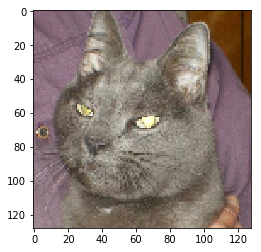

In [135]:
plt.imshow((arr[i]+1)/2);

In [136]:
val_gen_scl = base_gen(sz, scale_and_center, [preprocess_scale])
trn_gen_scl = base_gen(sz, scale_and_center, [preprocess_scale])
# trn_gen_scl = base_gen(sz, scale_and_center, [RandomFlip(), preprocess_scale])
val_gen_inet = base_gen(sz, scale_and_center, [preprocess_imagenet])
trn_gen_inet = base_gen(sz, scale_and_center, [preprocess_imagenet])
# trn_inet = base_gen(sz, scale_and_center, [RandomFlip(), preprocess_imagenet])

In [137]:
def scale_and_preprocess(x): return scale_and_center(preprocess_scale(x), sz)

In [138]:
ds_scl = ClassifierDataset.from_paths(path, trn_gen_scl, val_gen_scl, bs)

In [156]:
mn=MobileNet(include_top=False, input_shape=(sz,sz,3), alpha=1., pooling='avg')
md = Modeler(mn, ds_scl, ps=[0.])

-- freeze -1


In [9]:
xc=Xception(include_top=False, input_shape=(sz,sz,3), pooling='avg')
md = Modeler(xc, ds_scl)

20/21 [===========================>..] - ETA: 0s-- freeze -1


In [5]:
ds_inet = ClassifierDataset.from_paths(path, trn_gen_inet, val_gen_inet, bs)
rn=ResNet50(include_top=False, input_shape=(sz,sz,3), pooling='avg')
md = Modeler(rn, ds_inet)

20/21 [===========================>..] - ETA: 0s-- freeze -1


In [152]:
gen_scl = lambda x: preprocess_scale(scale_and_center(x, 128))

In [155]:
val_batches = FilesIter(val_fnames, val_y, gen_scl, shuffle=False, bs=bs)
fix_batches = FilesIter(fnames, y, gen_scl, shuffle=False, bs=bs)
trn_batches = FilesIter(fnames, y, gen_scl, shuffle=True, bs=bs)

In [148]:
gen = image.ImageDataGenerator(preprocessing_function=scale_and_preprocess)
val_batches = gen.flow_from_directory(f'{path}valid', (sz,sz), batch_size=bs, shuffle=False)
trn_batches = gen.flow_from_directory(f'{path}train', (sz,sz), batch_size=bs)
fix_batches = gen.flow_from_directory(f'{path}train', (sz,sz), batch_size=bs, shuffle=False)
nb_trn = math.ceil(trn_batches.n/bs)
nb_val = math.ceil(val_batches.n/bs)

Found 2000 images belonging to 2 classes.
Found 23000 images belonging to 2 classes.
Found 23000 images belonging to 2 classes.


In [157]:
md.set_lr(1e-2)

-- lr 0.01


In [158]:
md.model.fit_generator(trn_batches, nb_trn, workers=4, epochs=3,
                 validation_data=val_batches, validation_steps=nb_val)

Epoch 1/3
360/360 [==============================] - 28s - loss: 0.1415 - acc: 0.9503 - val_loss: 0.0865 - val_acc: 0.9675
Epoch 2/3
360/360 [==============================] - 27s - loss: 0.1063 - acc: 0.9636 - val_loss: 0.0889 - val_acc: 0.9690: 0.1068 - ETA
Epoch 3/3
360/360 [==============================] - 27s - loss: 0.0991 - acc: 0.9663 - val_loss: 0.0840 - val_acc: 0.9700


In [146]:
md.set_lr(1e-2)
md.train_fc(3)

-- lr 0.01
Epoch 1/3
360/360 [==============================] - 3s - loss: 0.0792 - acc: 0.9723 - val_loss: 0.0686 - val_acc: 0.9790
Epoch 2/3
360/360 [==============================] - 2s - loss: 0.0558 - acc: 0.9807 - val_loss: 0.0688 - val_acc: 0.9775
Epoch 3/3
360/360 [==============================] - 2s - loss: 0.0483 - acc: 0.9831 - val_loss: 0.0701 - val_acc: 0.9800


In [9]:
md.set_lr(1e-3)
md.train_fc(1)

-- lr 0.001
Epoch 1/1
360/360 [==============================] - 2s - loss: 0.0307 - acc: 0.9888 - val_loss: 0.0674 - val_acc: 0.9800


In [39]:
md.set_lr(1e-2)
md.train(3)

-- lr 0.01
Epoch 1/3
360/360 [==============================] - 37s - loss: 0.1318 - acc: 0.9543 - val_loss: 0.0872 - val_acc: 0.9640
Epoch 2/3
360/360 [==============================] - 37s - loss: 0.1094 - acc: 0.9625 - val_loss: 0.1657 - val_acc: 0.9490
Epoch 3/3
360/360 [==============================] - 37s - loss: 0.0946 - acc: 0.9662 - val_loss: 0.0875 - val_acc: 0.9710


In [10]:
md.set_lr(1e-3)
md.train(1)

-- lr 0.001
Epoch 1/1
360/360 [==============================] - 37s - loss: 0.0878 - acc: 0.9652 - val_loss: 0.0816 - val_acc: 0.9670


In [11]:
freeze_to(md.model, -9)

-- freeze -9


In [42]:
md.train(3)

Epoch 1/3
360/360 [==============================] - 38s - loss: 0.0645 - acc: 0.9773 - val_loss: 0.0784 - val_acc: 0.9725
Epoch 2/3
360/360 [==============================] - 36s - loss: 0.0550 - acc: 0.9786 - val_loss: 0.0655 - val_acc: 0.9730
Epoch 3/3
360/360 [==============================] - 37s - loss: 0.0410 - acc: 0.9832 - val_loss: 0.0710 - val_acc: 0.9720


In [185]:
isinstance(val_batches, Sequence)

False

In [44]:
md.set_lr(1e-4)
md.train(1)

-- lr 0.0001
Epoch 1/1
360/360 [==============================] - 38s - loss: 0.0341 - acc: 0.9875 - val_loss: 0.0702 - val_acc: 0.9710


In [39]:
freeze_to(md.model, 11)

-- freeze 11


In [40]:
md.set_lr(1e-4)

-- lr 0.0001


In [41]:
md.train(2)

Epoch 1/2
360/360 [==============================] - 63s - loss: 0.0407 - acc: 0.9850 - val_loss: 0.2120 - val_acc: 0.9680
Epoch 2/2
360/360 [==============================] - 60s - loss: 0.0374 - acc: 0.9868 - val_loss: 0.2234 - val_acc: 0.9665


In [18]:
unfreeze(md.model)

-- freeze 0


In [ ]:
# xception

In [9]:
ds_scl.train(md.model, 5)

Epoch 1/5
719/719 [==============================] - 290s - loss: 0.1941 - acc: 0.9603 - val_loss: 0.0730 - val_acc: 0.9830
Epoch 2/5
719/719 [==============================] - 286s - loss: 0.0691 - acc: 0.9819 - val_loss: 0.0494 - val_acc: 0.9860
Epoch 3/5
719/719 [==============================] - 286s - loss: 0.0530 - acc: 0.9843 - val_loss: 0.0396 - val_acc: 0.9875
Epoch 4/5
719/719 [==============================] - 286s - loss: 0.0492 - acc: 0.9839 - val_loss: 0.0357 - val_acc: 0.9875
Epoch 5/5
719/719 [==============================] - 287s - loss: 0.0470 - acc: 0.9846 - val_loss: 0.0330 - val_acc: 0.9895


In [10]:
freeze_to(md.model, 11)

-- freeze 11


In [11]:
ds_scl.train(md.model, 5.)

Epoch 1/5
719/719 [==============================] - 808s - loss: 0.0292 - acc: 0.9905 - val_loss: 0.0223 - val_acc: 0.9945
Epoch 2/5
719/719 [==============================] - 811s - loss: 0.0060 - acc: 0.9981 - val_loss: 0.0255 - val_acc: 0.9940
Epoch 3/5
719/719 [==============================] - 810s - loss: 0.0032 - acc: 0.9990 - val_loss: 0.0492 - val_acc: 0.9915
Epoch 4/5
719/719 [==============================] - 810s - loss: 0.0029 - acc: 0.9992 - val_loss: 0.0331 - val_acc: 0.9935
Epoch 5/5
719/719 [==============================] - 810s - loss: 0.0020 - acc: 0.9994 - val_loss: 0.0344 - val_acc: 0.9935


In [ ]:
# resnet

In [ ]:
ds_inet.train(md.model, 5)

In [ ]:
freeze_to(md.model, 11)

In [ ]:
ds_inet.train(md.model, 5)

In [3]:
ds = ClassifierDataset.from_paths(path, base_gen(224, scale_and_center), bs)
x,y = next(iter(ds.val_it))
plt.imshow(x[3]);

In [11]:
lidx = mf.layers.index(mf.get_layer('res5a_branch2a'))
for l in mf.layers[lidx:]: l.trainable=True